# Lab 4: Using trees to detect trees 
We will be using tree-based ensemble methods on the [Covertype dataset](https://www.openml.org/d/180).
It contains about 100,000 observations of 7 types of trees (Spruce, Pine, Cottonwood, Aspen,...) described by 55 features describing elevation, distance to water, soil type, etc.

In [1]:
%matplotlib inline
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openml
import time
from tqdm import tqdm, tqdm_notebook
import seaborn as sns # Plotting library, install with 'pip install seaborn'

In [2]:
# Download Covertype data. Takes a while the first time.
covertype = openml.datasets.get_dataset(180)
X, y, _, _ = covertype.get_data(target=covertype.default_target_attribute, dataset_format='array'); 
classes = covertype.retrieve_class_labels()
features = [f.name for i,f in covertype.features.items()][:-1]

In [3]:
classes

['Spruce_Fir',
 'Lodgepole_Pine',
 'Ponderosa_Pine',
 'Cottonwood_Willow',
 'Aspen',
 'Douglas_fir',
 'Krummholz']

In [4]:
features[0:20]

['elevation',
 'aspect',
 'slope',
 'horizontal_distance_to_hydrology',
 'Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Hillshade_9am',
 'Hillshade_Noon',
 'Hillshade_3pm',
 'Horizontal_Distance_To_Fire_Points',
 'wilderness_area1',
 'wilderness_area2',
 'wilderness_area3',
 'wilderness_area4',
 'soil_type_1',
 'soil_type_2',
 'soil_type_3',
 'soil_type_4',
 'soil_type_5',
 'soil_type_6']

To understand the data a bit better, we can use a scatter matrix. From this, it looks like elevation is a relevant feature.
Douglas Fir and Aspen grow at low elevations, while only Krummholz pines survive at very high elevations.

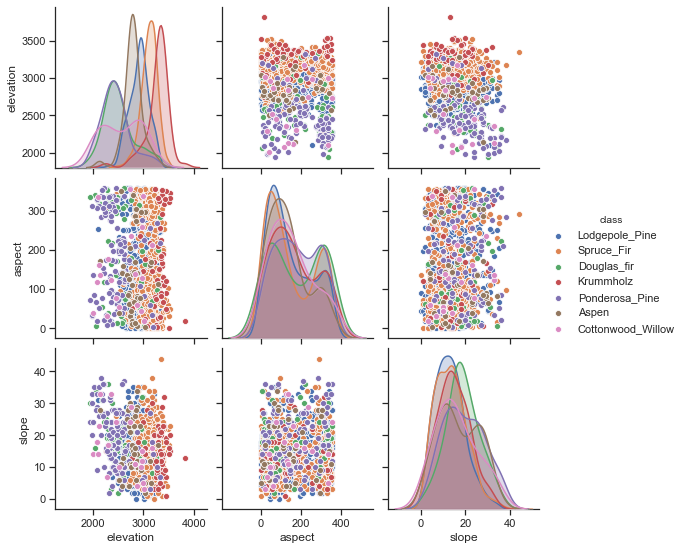

In [5]:
# Using seaborn to build the scatter matrix
# only first 3 columns, first 1000 examples
n_points = 1500
df = pd.DataFrame(X[:n_points,:3], columns=features[:3])
df['class'] = [classes[i] for i in y[:n_points]]
sns.set(style="ticks")
sns.pairplot(df, hue="class");

## Exercise 1: Random Forests
Implement a function `evaluate_RF` that measures the performance of a Random Forest Classifier, using trees
of (max) depth 2,8,32,64, for any number of trees in the ensemble (`n_estimators`). 
For the evaluation you should measure accuracy using 3-fold cross-validation. 
Use `random_state=1` to ensure reproducibility. Finally, plot the results for at least 5 values of `n_estimators` ranging from 1 to 30. You can, of course, reuse code from earlier labs and assignments. Interpret the results.
You can take a 50% subsample to speed the plotting.

In [6]:
## Model solution
from IPython import display
def plot_live(X, y, evaluator, param_name, param_range, scale='log', ylim=(0,1), ylabel='score', marker = '.'):
    """ Renders a plot that updates with every evaluation from evaluator.
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct labels
    evaluator -- a function with signature (X, y, param_value) that returns a dictionary of scores.
                 Examples: {"train": 0.9, "test": 0.95} or {"model_1": 0.9, "model_2": 0.7}
    param_name -- the parameter that is being varied on the X axis. Can be a hyperparameter, sample size,...
    param_range -- list of all possible values on the x-axis
    scale -- defines which scale to plot the x-axis on, either 'log' (logarithmic) or 'linear'
    ylim -- tuple with the lowest and highest y-value to plot (e.g. (0, 10))
    ylabel -- the y-axis title
    """
    # Plot interactively
    plt.ion()
    plt.ylabel(ylabel)
    plt.xlabel(param_name)
    
    # Make the scale look nice
    plt.xscale(scale)
    plt.xlim(param_range[0],param_range[-1])
    plt.ylim(ylim)
        
    # Start from empty plot, then fill it
    series = {}
    lines = {}
    xvals = []
    for i in param_range:
        scores = evaluator(X, y, i) 
        if i == param_range[0]: # initialize series
            for k in scores.keys():
                lines[k], = plt.plot(xvals, [], marker = marker, label = k)
                series[k] = []
        xvals.append(i)
        for k in scores.keys(): # append new data
            series[k].append(scores[k])
            lines[k].set_data(xvals, series[k])
        # refresh plot
        plt.legend(loc='best')
        plt.margins(0.1)
        display.display(plt.gcf())
        display.clear_output(wait=True)

In [7]:
## Model solution
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import balanced_accuracy_score
from xgboost import XGBClassifier

def evaluate_RF(X, y, n_estimators, max_depth=[2,8,32,64], scoring='accuracy'):
    """ Evaluate a Random Forest classifier using 3-fold cross-validation on the provided (X, y) data. 
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct labels
    n_estimators -- the value for the gamma parameter
    
    Returns: a dictionary with the train and test score, e.g. {"rf_1": 0.9, "rf_2": 0.95}
    """
    res = {}
    for md in max_depth:
        rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=md, random_state=1)
        res['rf_'+str(md)] = np.mean(cross_val_score(rf,X,y,cv=3,scoring=scoring))
    return res

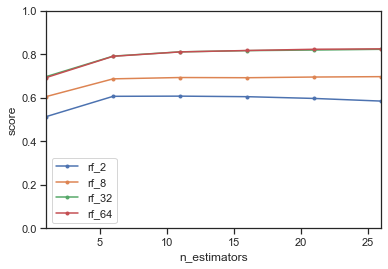

In [8]:
def plot_1(X, y, evaluator):
    Xs, _, ys, _ = train_test_split(X,y, stratify=y, train_size=0.5, random_state=1)
    param_name = 'n_estimators'
    param_range = range(1, 32, 5)
    plot_live(Xs, ys, evaluator, param_name, param_range, scale='linear')
plot_1(X, y, evaluate_RF)

Overall, the more trees, the better the score. The depth of the tree has a much larger
effect though. Trees smaller than 32 do not perform well in the ensemble.
This is to be expected, since Random Forests is a variance-reduction technique. It will
only work if the trees are allowed to overfit. If they underfit, building a random forest
ensemble of them won't help. However, trees deeper than 32 do not further improve the score, likely because the trees don't grow much deeper on this dataset.

## Exercise 2: Other measures
Repeat the same plot but now use balanced_accuracy as the evaluation measure. See the [documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score).
Only use the optimal max_depth from the previous question. Do you see an important difference?

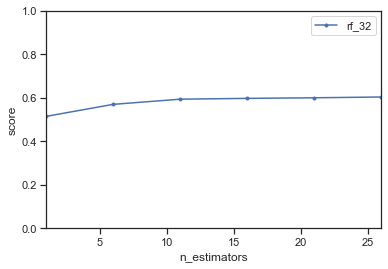

In [9]:
## Model solution
def evaluate_RF_balanced(X,y,n_estimators):
    return evaluate_RF(X,y,n_estimators,max_depth=[32], scoring='balanced_accuracy')
plot_1(X, y, evaluate_RF_balanced)

## Exercise 3: Feature importance
Retrieve the feature importances according to the (tuned) random forest model. Which feature are most important?

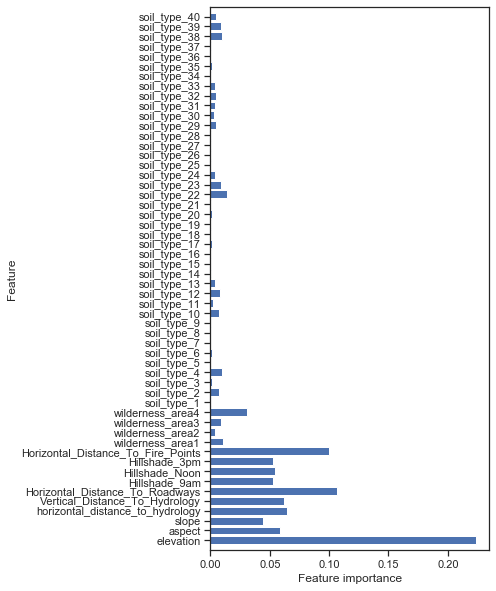

In [10]:
## Model solution
def plot_feature_importances(features, model):
    n_features = len(features)
    plt.figure(figsize=(5,10))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(range(n_features), features)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

forest = RandomForestClassifier(random_state=0, n_estimators=25, max_depth=32, n_jobs=-1)
forest.fit(X,y)
plt.rcParams.update({'font.size':8})
plot_feature_importances(features, forest)

## Exercise 4: Feature selection
Re-build your tuned random forest, but this time only using the first 10 features.
Return both the balanced accuracy and training time. Interpret the results.

In [11]:
# Model Solution
start = time.time()
score = evaluate_RF(X,y,25,max_depth=[32], scoring='balanced_accuracy')
print("Normal RF: {:.2f} balanced ACC, {:.2f} seconds".format(score['rf_32'], (time.time()-start)))
start = time.time()
score = evaluate_RF(X[:,0:10],y,25,max_depth=[32], scoring='balanced_accuracy')
print("Feature Selection RF: {:.2f} balanced ACC, {:.2f} seconds".format(score['rf_32'], (time.time()-start)))

Normal RF: 0.65 balanced ACC, 15.26 seconds
Feature Selection RF: 0.62 balanced ACC, 16.49 seconds


The first 10 features are the most significant according to the random forest. If we select only those, we get a very similar (but slightly worse) result. Random forests is already very robust against irrelevant features. Removing irrelevant features
in this way doesn't help much. The runtime is also about the same.

## Exercise 5: Confusion matrix
Do a standard stratified holdout and generate the confusion matrix of the tuned random forest. Which classes are still often confused?

In [12]:
# Model Solution
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=1)
tuned_forest = RandomForestClassifier(random_state=0, n_estimators=25, max_depth=32, n_jobs=-1).fit(X_train, y_train)

In [13]:
# Model Solution
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, tuned_forest.predict(X_test))

array([[ 8475,  1059,    41,    20,    30,    23,    79],
       [  661, 12032,    73,    22,    35,    67,    31],
       [   83,   167,  1510,     8,    10,    55,    11],
       [   81,   114,    39,    81,     4,    12,     4],
       [  103,   250,    19,     3,   260,    11,     7],
       [   89,   173,   113,     5,     2,   600,    10],
       [  173,   121,    14,     2,    10,     8,   799]])

## Exercise 6: A second-level model
Build a binary model specifically to correctly choose between the first and the second class.
Select only the data points with those classes and train a new random forest. Do a standard stratified split and plot the resulting ROC curve. Can we still improve the model by calibrating the threshold?

In [14]:
# Model Solution
X_bin = X[y < 2, :]
y_bin = y[y < 2]

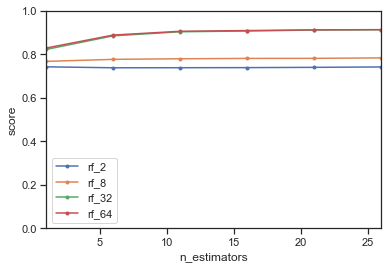

In [15]:
# Model Solution
def plot_1(X, y, evaluator):
    param_name = 'n_estimators'
    param_range = range(1, 32, 5)
    plot_live(X, y, evaluator, param_name, param_range, scale='linear')
plot_1(X_bin, y_bin, evaluate_RF)

The previously tuned hyperparameters are still good.

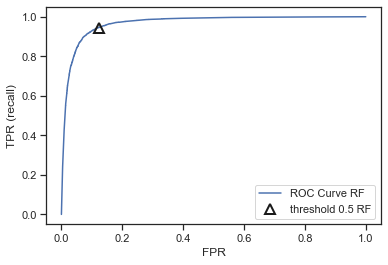

In [16]:
# Model Solution
from sklearn.metrics import roc_curve

X_train, X_test, y_train, y_test = train_test_split(X_bin,y_bin, stratify=y_bin, random_state=1)
binary_forest = RandomForestClassifier(random_state=0, n_estimators=25, max_depth=32, n_jobs=-1).fit(X_train, y_train)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, binary_forest.predict_proba(X_test)[:, 1])

plt.plot(fpr_rf, tpr_rf, label="ROC Curve RF")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(fpr_rf[close_default_rf], tpr_rf[close_default_rf], '^', markersize=10,
         label="threshold 0.5 RF", fillstyle="none", c='k', mew=2)
plt.legend(loc=4);

Yes, we want to be in the top left corner. Setting the threshold at 0.6 seems te be better.

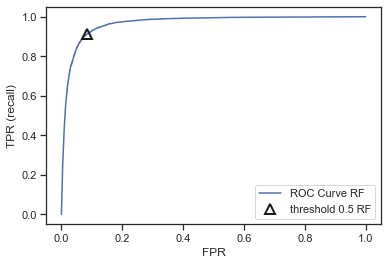

In [17]:
# Model Solution
# Too much code replication
plt.plot(fpr_rf, tpr_rf, label="ROC Curve RF")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
close_default_rf = np.argmin(np.abs(thresholds_rf - 0.6))
plt.plot(fpr_rf[close_default_rf], tpr_rf[close_default_rf], '^', markersize=10,
         label="threshold 0.5 RF", fillstyle="none", c='k', mew=2)
plt.legend(loc=4);

## Exercise 7: Model calibration
For the trained binary random forest model, plot a calibration curve (see [course notebook](https://ml-course.github.io/engineer/slides_html/03%20-%20Model%20Selection.slides.html#/40)). 
Next, try to correct for this using Platt Scaling (or sigmoid scaling).

Probability calibration should be done on new data not used for model fitting. The class [CalibratedClassifierCV](https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py) uses a cross-validation generator and estimates for each split the model parameter on the train samples and the calibration of the test samples. The probabilities predicted for the folds are then averaged. Already fitted classifiers can be calibrated by CalibratedClassifierCV via the parameter cv=”prefit”. [Read more](https://scikit-learn.org/stable/modules/calibration.html)

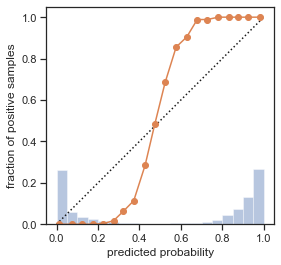

In [18]:
# Model Solution
from sklearn.calibration import calibration_curve
def plot_calibration_curve(y_true, y_prob, n_bins=5, ax=None, hist=True, normalize=False):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, normalize=normalize)
    if ax is None:
        ax = plt.gca()
    if hist:
        ax.hist(y_prob, weights=np.ones_like(y_prob) / len(y_prob), alpha=.4,
               bins=np.maximum(10, n_bins))
    ax.plot([0, 1], [0, 1], ':', c='k')
    curve = ax.plot(prob_pred, prob_true, marker="o")

    ax.set_xlabel("predicted probability")
    ax.set_ylabel("fraction of positive samples")

    ax.set(aspect='equal')
    return curve

X_train, X_test, y_train, y_test = train_test_split(X_bin,y_bin, stratify=y_bin, random_state=1)
binary_forest = RandomForestClassifier(random_state=0, n_estimators=25, max_depth=32, n_jobs=-1).fit(X_train, y_train)
scores = forest.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, scores, n_bins=20);

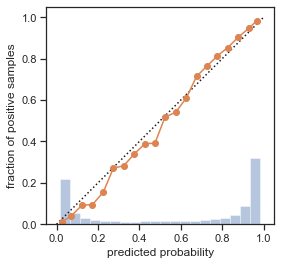

In [19]:
# Model Solution
from sklearn.calibration import CalibratedClassifierCV
rf = RandomForestClassifier(random_state=0, n_estimators=25, max_depth=32, n_jobs=-1) #Unfitted RF
sigmoid = CalibratedClassifierCV(rf, cv=2, method='sigmoid')
sigmoid.fit(X_train, y_train)
y_pred = sigmoid.predict(X_test)
prob_pos = sigmoid.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, prob_pos, n_bins=20);

## Exercise 8: Gradient Boosting
Implement a function `evaluate_GB` that measures the performance of `GradientBoostingClassifier` or the `XGBoostClassifier` for 
different learning rates (0.01, 0.1, 1, and 10). As before, use a 3-fold cross-validation. You can use a 5% stratified sample of the whole dataset.
Finally plot the results for `n_estimators` ranging from 1 to 100. Run all the GBClassifiers with `random_state=1` to ensure reproducibility.

Implement a function that plots the score of `evaluate_GB` for `n_estimators` = 10,20,30,...,100 on a linear scale.

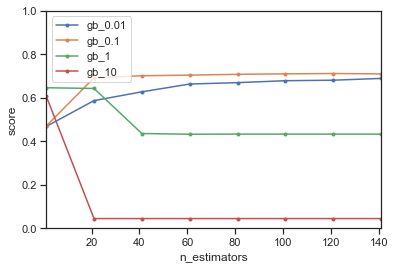

In [23]:
# Model Solution
# This could be done more efficiently using warm starting

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from xgboost import XGBClassifier

def evaluate_GB(X, y, n_estimators, learning_rate=[0.01,0.1,1,10], scoring='accuracy'):
    res = {}
    for lr in learning_rate:
        rf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=lr, random_state=1)
        kfold = StratifiedKFold(n_splits=3, random_state=1, shuffle=True)
        res['gb_'+str(lr)] = np.mean(cross_val_score(rf,X,y,cv=kfold,scoring=scoring))
    return res

def plot_2(X, y, evaluator):
    Xs, _, ys, _ = train_test_split(X,y, stratify=y, train_size=0.05, random_state=1)
    param_name = 'n_estimators'
    param_range = range(1, 150, 20)
    plot_live(Xs, ys, evaluator, param_name, param_range, scale='linear')
plot_2(X, y, evaluate_GB)

We notice that gradient boosting is a lot slower to train that random forests, and it performs less well (at least when using fewer than 150 iterations).
A smaller learning rate requires more iterations but ultimately works out best. It is possible that the model with learning rate 0.01 will ultimately overtake the one with learning rate 0.1 but it may also take a long time.

A learning rate that is too large performs poorly. For `learning_rate=1`, the model starts out well, but gradually performs worse. The instance weights are adapted so aggressively that the next model does not actually fix the mistakes of the previous model but 'overshoots' and introduces more errors in the ensemble. After a while, it is not capable to make fine enough adjustments and levels off, not improving the model anymore. [A more detailed explanation can be read here](https://mlexplained.com/2018/01/29/learning-rate-tuning-in-deep-learning-a-practical-guide/).